# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that you've seen some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modeling pipeline.  

With this pipeline, you will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modeling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. You've seen the bias variance trade-off, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modeling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

Load and preview the dataset below.

In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df=pd.read_csv('loan_final.csv')
df.dropna(subset=['total_pymnt'],inplace=True)
df.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,total_acc,total_pymnt,application_type
0,5000.0,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,9.0,5863.155187,Individual
1,2500.0,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,4.0,1014.530000,Individual
2,2400.0,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,10.0,3005.666844,Individual
3,10000.0,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,37.0,12231.890000,Individual
4,3000.0,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Fully Paid,other,OR,38.0,4066.908161,Individual


## Defining the Problem

Set up the problem by defining X and y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Our target variable y will be ```total_pymnt```

In [3]:
# appropriately define X and y and apply a train test split
X=df.loc[:,['loan_amnt','home_ownership','funded_amnt_inv','verification_status','emp_length','installment','annual_inc']]
y=df.loc[:,'total_pymnt']

## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modeling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

*Note: Using a test size of 10% caused the model not to converge so that had to be dropped*

In [4]:
# generate a hold out test set for final model evaluation. Use random seed 123.
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=123)

### Preprocessing Steps
* Fill in missing values with SimpleImputer
* Standardize continuous features with StandardScalar()
* One hot encode categorical features with OneHotEncoder()

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31901 entries, 41522 to 15725
Data columns (total 7 columns):
loan_amnt              31901 non-null float64
home_ownership         31901 non-null object
funded_amnt_inv        31901 non-null float64
verification_status    31901 non-null object
emp_length             31108 non-null object
installment            31901 non-null float64
annual_inc             31897 non-null float64
dtypes: float64(4), object(3)
memory usage: 1.9+ MB


In [6]:
from sklearn.impute import SimpleImputer
num_columns=['loan_amnt','funded_amnt_inv','installment','annual_inc']
str_columns=['home_ownership','verification_status','emp_length']

X_train_num=X_train.loc[:,num_columns]
imp_mean=SimpleImputer(missing_values=np.nan,strategy='mean')
X_train_num=imp_mean.fit_transform(X_train_num)

X_train_cat=X_train.loc[:,str_columns]
imp_freq=SimpleImputer(strategy='constant', fill_value='missing')
X_train_cat=imp_freq.fit_transform(X_train_cat)

In [7]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
ss=StandardScaler()
X_train_num=ss.fit_transform(X_train_num)
X_train_num=pd.DataFrame(X_train_num,columns=num_columns)
X_train_num.head()

,loan_amnt,funded_amnt_inv,installment,annual_inc
0,-0.716277,-1.316047,-0.622372,-0.649962
1,0.252926,0.392249,0.552459,-0.585531
2,0.118314,0.255956,-0.202807,0.237043
3,-0.420131,-0.303194,-0.265850,0.155683
4,-0.689354,-0.586263,-0.610549,0.042617


In [8]:
ohe=OneHotEncoder()
X_train_cat=ohe.fit_transform(X_train_cat).todense()
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names(input_features=str_columns))
X_train_cat.head()

,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_missing
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X_train_proc=pd.concat([X_train_num,X_train_cat],axis=1)
X_train_proc.head()

,loan_amnt,funded_amnt_inv,installment,annual_inc,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,...,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_missing
0,-0.716277,-1.316047,-0.622372,-0.649962,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.252926,0.392249,0.552459,-0.585531,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.118314,0.255956,-0.202807,0.237043,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.420131,-0.303194,-0.265850,0.155683,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.689354,-0.586263,-0.610549,0.042617,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocess Your Holdout Set

Make sure to use your StandardScalar and OneHotEncoder that you already fit on the training set to transform your test set

In [10]:
X_test_num=X_test.loc[:,num_columns]
X_test_cat=X_test.loc[:,str_columns]

X_test_num=imp_mean.transform(X_test_num)
X_test_cat=imp_freq.transform(X_test_cat)

X_test_num=ss.transform(X_test_num)
X_test_num=pd.DataFrame(X_test_num,columns=num_columns)

X_test_cat=ohe.transform(X_test_cat).todense()
X_test_cat = pd.DataFrame(X_test_cat, columns=ohe.get_feature_names(input_features=str_columns))

X_test_proc=pd.concat([X_test_num,X_test_cat],axis=1)

## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. 

> Note: Think about how you will analyze the output of your models in order to select an optimal model. This may involve graphs, although alternative approaches are certainly feasible.

In [11]:
# define a function to evaluate a model object using K folds cross validation.
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = []
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        
        row = i//5
        col = i%5
        
        X_train_k, X_val_k = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train_k, y_val_k = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        
        hist = model.fit(X_train_k, y_train_k, batch_size=32,
                         epochs=n_epochs, verbose=0, validation_data = (X_val_k, y_val_k))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val_k, y_val_k)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
        
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model. Additionally, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. Since this dataset is not overly large, it will be most appropriate to set up a k-folds cross-validation  

In [12]:
# define and compile an initial model as described
from keras.models import Sequential
from keras.layers import Dense

input_dimension=X_train_proc.shape[1]
model=Sequential()
model.add(Dense(7,input_dim=input_dimension,kernel_initializer='normal',activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,kernel_initializer='normal',activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

3190/3190 [==============================] - 0s 51us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:41:16.993975


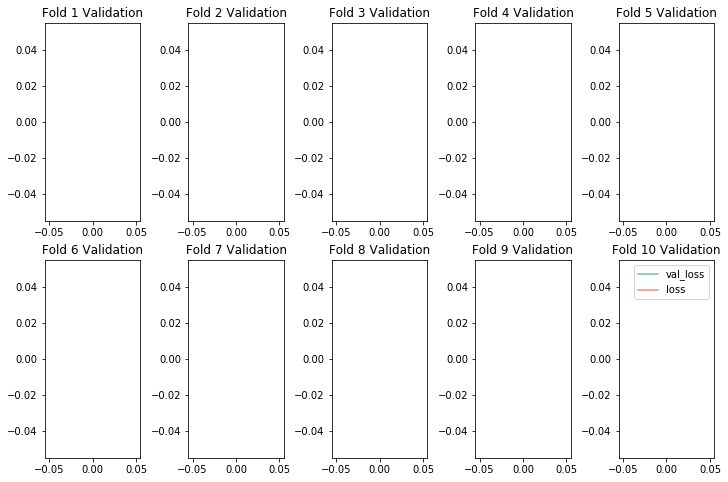

In [13]:
# use your k-folds function to evaluate the baseline model.
# ⏰ This cell may take several mintes to run
import time
import datetime
start=datetime.datetime.now()

k_folds(X_train_proc, y_train, model)

end=datetime.datetime.now()
elapsed=end-start
print(f"Time Elapsed: {elapsed}")

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.

3190/3190 [==============================] - 0s 36us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:41:01.643516


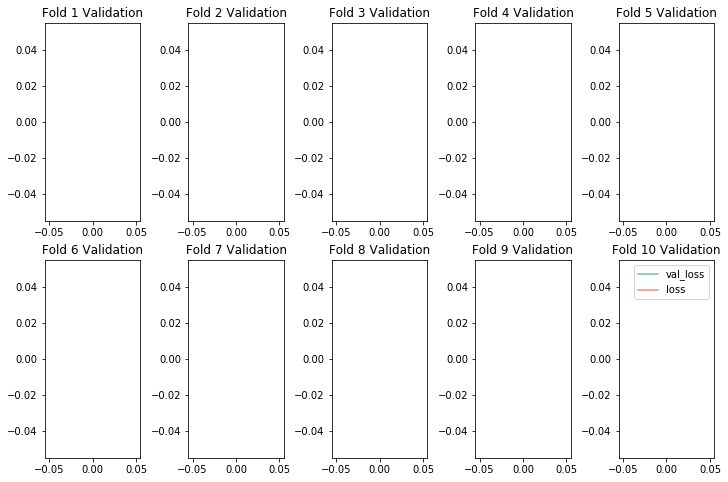

In [14]:
# Model 2: more layers!
# ⏰ This cell may take several minutes to run
model2=Sequential()
model2.add(Dense(7,input_dim=input_dimension,kernel_initializer='normal',activation='relu'))
model2.add(Dense(10,activation='relu'))
model2.add(Dense(10,activation='relu'))
model2.add(Dense(1,kernel_initializer='normal',activation='linear'))
model2.compile(optimizer='sgd',loss='mse',metrics=['mse'])

start=datetime.datetime.now()

k_folds(X_train_proc, y_train, model2)

end=datetime.datetime.now()
elapsed=end-start
print(f"Time Elapsed: {elapsed}")

3190/3190 [==============================] - 0s 101us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:30:19.191356


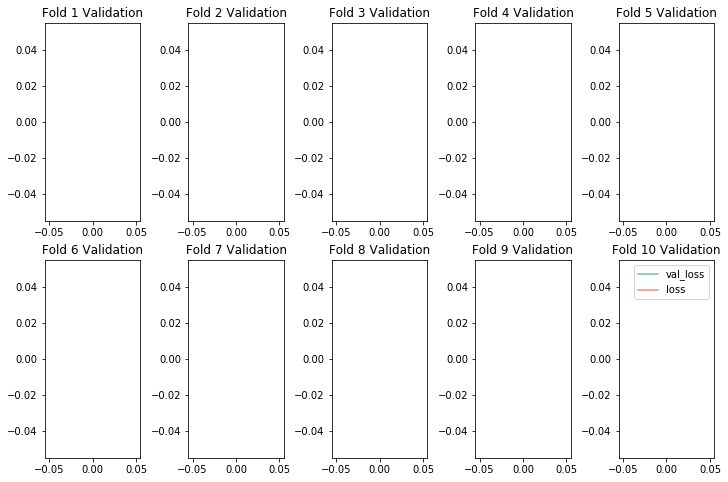

In [15]:
# Model 3: bigger layers!
# ⏰ This cell may take several minutes to run
model3=Sequential()
model3.add(Dense(10,input_dim=input_dimension,kernel_initializer='normal',activation='relu'))
model3.add(Dense(13,activation='relu'))
model3.add(Dense(1,kernel_initializer='normal',activation='linear'))
model3.compile(optimizer='sgd',loss='mse',metrics=['mse'])

start=datetime.datetime.now()

k_folds(X_train_proc, y_train, model3)

end=datetime.datetime.now()
elapsed=end-start
print(f"Time Elapsed: {elapsed}")

3190/3190 [==============================] - 0s 53us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:47:24.803487


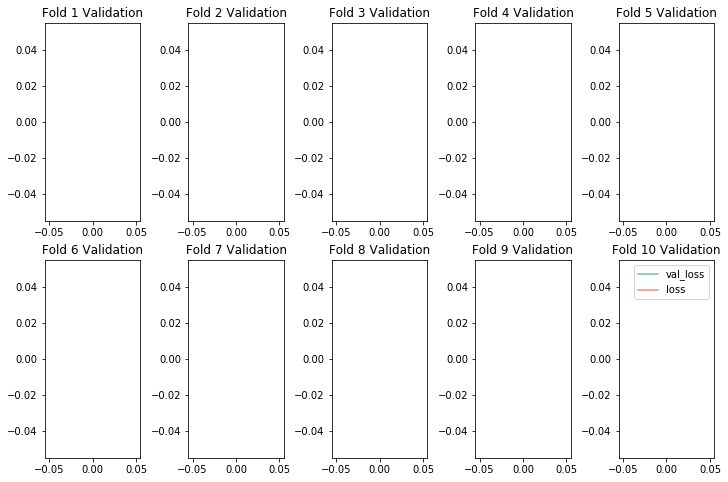

In [16]:
# Model 4: More epoch!
# ⏰ This cell may take several mintes to run
model4=Sequential()
model4.add(Dense(7,input_dim=input_dimension,kernel_initializer='normal',activation='relu'))
model4.add(Dense(10,activation='relu'))
model4.add(Dense(1,kernel_initializer='normal',activation='linear'))
model4.compile(optimizer='sgd',loss='mse',metrics=['mse'])

start=datetime.datetime.now()

k_folds(X_train_proc, y_train, model4,n_epochs=120)

end=datetime.datetime.now()
elapsed=end-start
print(f"Time Elapsed: {elapsed}")

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

3190/3190 [==============================] - 0s 65us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:37:44.090367


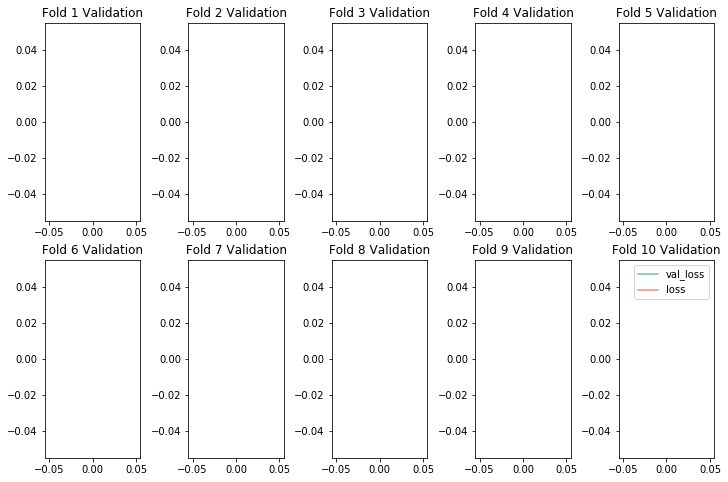

In [17]:
# Model 5: L1 Regularization!
# ⏰ This cell may take several minutes to run

from keras import regularizers

model5=Sequential()
model5.add(Dense(7,input_dim=input_dimension,kernel_initializer='normal',activation='relu'))
model5.add(Dense(10,kernel_regularizer=regularizers.l1(0.005),activation='relu'))
model5.add(Dense(1,kernel_initializer='normal',activation='linear'))
model5.compile(optimizer='sgd',loss='mse',metrics=['mse'])

start=datetime.datetime.now()

k_folds(X_train_proc, y_train, model5)

end=datetime.datetime.now()
elapsed=end-start
print(f"Time Elapsed: {elapsed}")

3190/3190 [==============================] - 0s 48us/step
Mean Validation Score: 3.4496178970926475e+29
Standard Deviation of Validation Scores: 1.5036535556584827e+30
Time Elapsed: 0:38:41.396308


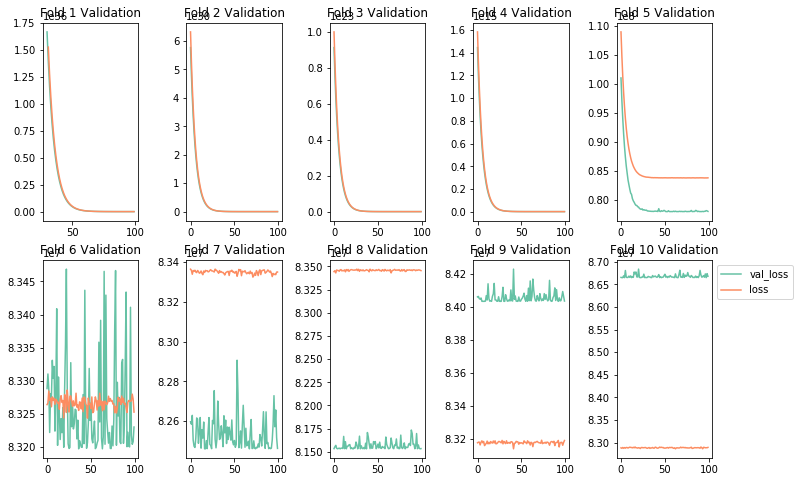

In [18]:
# Model 6: L2 Regularization!
# ⏰ This cell may take several minutes to run

model6=Sequential()
model6.add(Dense(7,input_dim=input_dimension,kernel_initializer='normal',activation='relu'))
model6.add(Dense(10,kernel_regularizer=regularizers.l2(0.005),activation='relu'))
model6.add(Dense(1,kernel_initializer='normal',activation='linear'))
model6.compile(optimizer='sgd',loss='mse',metrics=['mse'])

start=datetime.datetime.now()

k_folds(X_train_proc, y_train, model6)

end=datetime.datetime.now()
elapsed=end-start
print(f"Time Elapsed: {elapsed}")

3190/3190 [==============================] - 0s 88us/step
Mean Validation Score: nan
Standard Deviation of Validation Scores: nan
Time Elapsed: 0:42:41.555420


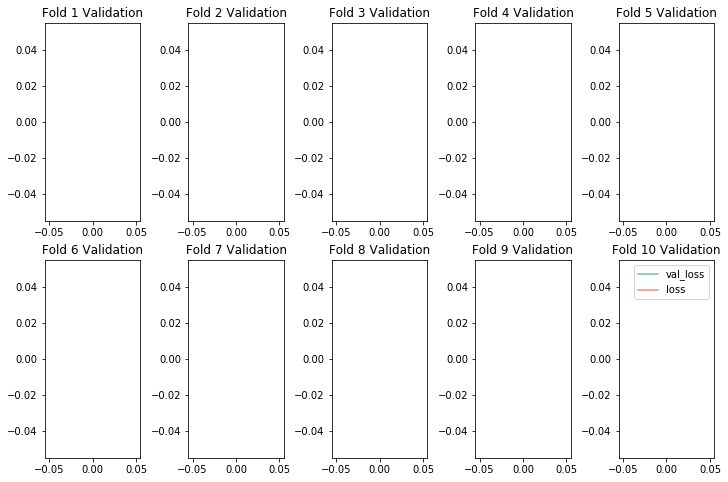

In [19]:
# Model 7: Dropout!
# ⏰ This cell may take several minutes to run
from keras.layers import Dropout

model7=Sequential()
model7.add(Dense(7,input_dim=input_dimension,kernel_initializer='normal',activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(10,activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(1,kernel_initializer='normal',activation='linear'))
model7.compile(optimizer='sgd',loss='mse',metrics=['mse'])

start=datetime.datetime.now()

k_folds(X_train_proc, y_train, model7)

end=datetime.datetime.now()
elapsed=end-start
print(f"Time Elapsed: {elapsed}")

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your experiments above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modeling process)!

In [20]:
# Final Model!
# ⏰ This cell may take several minutes to run

start = datetime.datetime.now()

input_dimension = X_train_proc.shape[1]
model8=Sequential()
model8.add(Dense(7,input_dim=input_dimension,kernel_initializer='normal',activation='relu'))
model8.add(Dense(10,activation='relu'))
model8.add(Dense(1,kernel_initializer='normal',activation='linear'))
model8.compile(optimizer='sgd',loss='mse',metrics=['mse'])

model8.fit(X_train_proc, y_train, batch_size=32, epochs=75)

end = datetime.datetime.now()
elapsed = end - start
print('Time Elapsed:', elapsed)

Epoch 1/75
31901/31901 [==============================] - 4s 116us/step - loss: nan - mse: nan
Epoch 2/75
31901/31901 [==============================] - 3s 97us/step - loss: nan - mse: nan
Epoch 3/75
31901/31901 [==============================] - 3s 95us/step - loss: nan - mse: nan
Epoch 4/75
31901/31901 [==============================] - 3s 89us/step - loss: nan - mse: nan
Epoch 5/75
31901/31901 [==============================] - 3s 88us/step - loss: nan - mse: nan
Epoch 6/75
31901/31901 [==============================] - 3s 90us/step - loss: nan - mse: nan
Epoch 7/75
31901/31901 [==============================] - 3s 90us/step - loss: nan - mse: nan
Epoch 8/75
31901/31901 [==============================] - 3s 90us/step - loss: nan - mse: nan
Epoch 9/75
31901/31901 [==============================] - 3s 90us/step - loss: nan - mse: nan
Epoch 10/75
31901/31901 [==============================] - 3s 90us/step - loss: nan - mse: nan
Epoch 11/75
31901/31901 [==============================] -

In [21]:
model.evaluate(X_test_proc, y_test)

10634/10634 [==============================] - 1s 75us/step


[nan, nan]

## Summary

In this lab, you investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. You began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, you implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, you'll begin to investigate other neural network architectures such as CNNs.